# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [3]:
import tarfile
import os
from skimage.segmentation import slic, join_segmentations, watershed
from skimage.measure import label
from skimage.color import label2rgb
from skimage import exposure
import sys
import cv2
import numpy as np

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

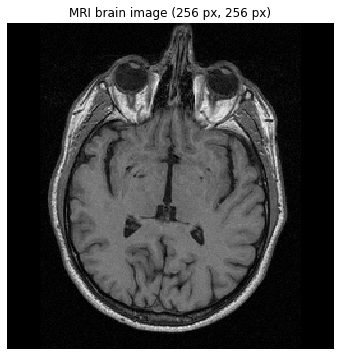

In [4]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

### 1.3 Contour detection
Add your implementation and discussion

### 1.4 Additional method(s)

#### 1.4.1 Simple Thresholding

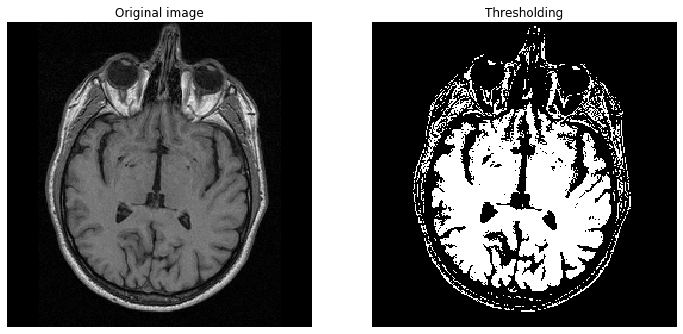

In [5]:
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))

brain_copy = np.copy(brain_im)
sample1 = [140, 140]
sample2 = [86,76]

def thresholding(image, base_lvl, delta):
    copy = np.copy(image)
    mask = np.abs(copy[:,:] - base_lvl) < delta
    copy[mask] = 255
    copy[np.logical_not(mask)] = 0
    return copy

delta = 20
base_lvl = np.mean(brain_im[152:162,75:85])
thresh = thresholding(brain_im, base_lvl, delta)

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(brain_im, cmap ='gray')
ax[0].set_title('Original image')
ax[1].imshow(thresh, cmap='gray')
ax[1].set_title('Thresholding')
for a in ax:
    a.axis('off')
plt.show()

#### 1.4.2 Adding Closing and Opening operators

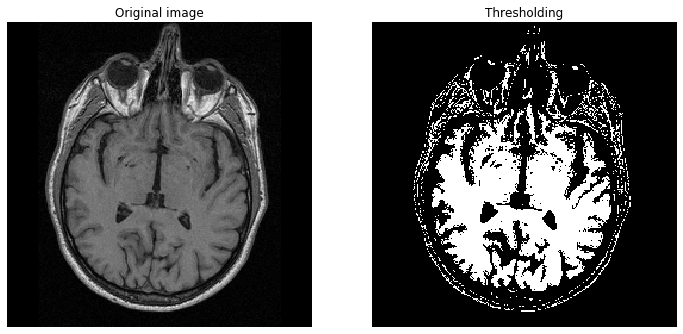

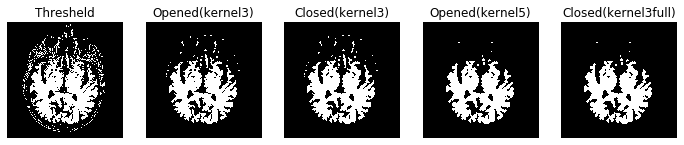

There are 11474 pixels of the brain using thresholding and opening-closing method.


In [6]:
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))

def dilating(image, kernel): # kernel must be symmetric
    im_h, im_w = image.shape
    h, w = kernel.shape
    h = int((h-1)/2)
    w = int((w-1)/2) # borders
    
    dilated = np.zeros((im_h, im_w))
    
    for i in range(h,im_h-h):
        for j in range(w, im_w-w):
            if image[i,j] == 255:
                dilated[i-h:i+h+1, j-w:j+w+1] = dilated[i-h:i+h+1, j-w:j+w+1] + kernel
    dilated[dilated[:,:] > 255] = 255
    
    return dilated

def eroding(image, kernel): # kernel must be symmetric
    
    im_h, im_w = image.shape
    h, w = kernel.shape
    h_offset = int((h-1)/2)
    w_offset = int((w-1)/2) # borders
    
    eroded = np.zeros((im_h, im_w))
    
    for i in range(h_offset, im_h - h_offset):
        for j in range(w_offset, im_w - w_offset):
            if image[i,j] == 255:
                small_img = np.copy(image[i-h_offset:i+h_offset+1, j-w_offset:j+w_offset+1])
                small_img[kernel == 0] = 0
                
                if np.all(kernel == small_img):
                    eroded[i,j] = 255
    
    return eroded

def opening(image, kernel):
    eroded = eroding(image, kernel)
    opened = dilating(eroded, kernel)
    return opened

def closing(image, kernel):
    dilated = dilating(image, kernel)
    closed = eroding(dilated, kernel)
    return closed

data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))

brain_copy = np.copy(brain_im)
sample1 = [140, 140]
sample2 = [86,76]

def thresholding(image, base_lvl, delta):
    copy = np.copy(image)
    mask = np.abs(copy[:,:] - base_lvl) < delta
    copy[mask] = 255
    copy[np.logical_not(mask)] = 0
    return copy

delta = 16
base_lvl = np.mean(brain_im[152:162,75:85])
thresh = thresholding(brain_im, base_lvl, delta)

fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(brain_im, cmap ='gray')
ax[0].set_title('Original image')
ax[1].imshow(thresh, cmap='gray')
ax[1].set_title('Thresholding')
for a in ax:
    a.axis('off')
plt.show()

kernel7 = np.array([[0,0,0,255,0,0,0],[0,0,255,255,255,0,0],[0,255,255,255,255,255,0],
                    [255,255,255,255,255,255,255],[0,255,255,255,255,255,0],
                    [0,0,255,255,255,0,0],[0,0,0,255,0,0,0]]) #7x7
kernel5 = np.array([[0,0,255,0,0],[0,255,255,255,0],[255,255,255,255,255],[0,255,255,255,0],[0,0,255,0,0]]) # 5x5
kernel3 = np.array([[0,255,0],[255,255,255],[0,255,0]]) # 3x3
kernel3full = np.ones((3,3))*255

fig, ax = plt.subplots(1, 5, figsize = (12, 7))
ax[0].imshow(thresh, cmap = 'gray')
ax[0].set_title('Thresheld')

brain_opened = opening(thresh, kernel3)
ax[1].imshow(brain_opened, cmap = 'gray')
ax[1].set_title('Opened(kernel3)')

brain_closed = closing(brain_opened, kernel3)
ax[2].imshow(brain_closed, cmap = 'gray')
ax[2].set_title('Closed(kernel3)')

brain_final = opening(brain_closed, kernel5)
ax[3].imshow(brain_final, cmap = 'gray')
ax[3].set_title('Opened(kernel5)')

brain_final2 = closing(brain_final, kernel3full)
ax[4].imshow(brain_final, cmap = 'gray')
ax[4].set_title('Closed(kernel3full)')

for a in ax:
    a.axis('off')

plt.show()

ua,uind=np.unique(brain_final, return_inverse = True)
count=np.bincount(uind)
print('There are {} pixels of the brain using thresholding and opening-closing method.'.format(count[1]))

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [7]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


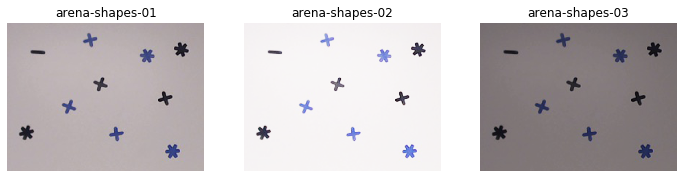

In [8]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

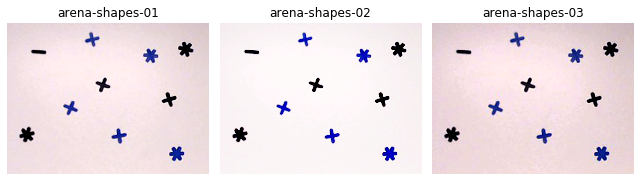

In [9]:
# Contrast stretching
p2, p98 = np.percentile(images[0], (1, 98))
p21, p981 = np.percentile(images[1], (2, 98))
p22, p982 = np.percentile(images[2], (1, 98))

newim1 = exposure.rescale_intensity(images[0], in_range=(p2, p98))
newim2 = exposure.rescale_intensity(images[1], in_range=(p21, p981))
newim3 = exposure.rescale_intensity(images[2], in_range=(p22, p982))

#contains the new images. dimenstions[3 480 640 3]
new_images = np.array([newim1, newim2, newim3])

# Display images
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(9, 5),
                     sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(newim1, cmap='gray')
ax[0].set_title('arena-shapes-01')

ax[1].imshow(newim2, cmap='gray')
ax[1].set_title('arena-shapes-02')

ax[2].imshow(newim3, cmap='gray')
ax[2].set_title('arena-shapes-03')

for a in ax:
    a.axis('off')
fig.tight_layout()


plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

In [10]:
def region_growing(image, origin, delta):
    """
    Inputs:
    
    image =: image to apply region growing algorithm to
    origin =: indices of the pixel where the algorithm should start
    delta_min =: threshold minimum value
    delta_max =: threshold maximum value
    
    -----------------------------------
    Outputs:
    region =: boolean map, True indicates that it belongs to the grown region
"""
    
    # Image size
    im_h, im_w, _ = image[:,:,:].shape
    
    # Initialisation
    to_be_explored = [tuple(origin)]
    explored = set()
    region = np.zeros((im_h, im_w)).astype(bool)
    base_lvl = image[tuple(origin)]
    
    while len(to_be_explored):
        i,j = to_be_explored.pop()
        explored.add((i,j))
        diff_to_base_lvl = lin.norm(np.subtract(image[i,j], base_lvl), 2, None, False)
        if not diff_to_base_lvl < delta:
            continue
        region[i,j] = True
        if i > 0:
            if (i-1, j) not in explored:
                to_be_explored.append((i-1, j))
        if j > 0:
            if (i, j-1) not in explored:
                to_be_explored.append((i, j-1))
        if i < (im_h-1):
            if (i+1, j) not in explored:
                to_be_explored.append((i+1, j))
        if j < (im_w-1):
            if (i, j+1) not in explored:
                to_be_explored.append((i, j+1))
    
    return region

In [11]:
a = np.zeros((3,3)).astype(bool)
a[1,1] = True
print(a)

b = (1,1)
print(a[b])

[[False False False]
 [False  True False]
 [False False False]]
True


In [38]:
def find_regions(image, delta):
    """
    Inputs:
    
    image =: image to cluster regions and group regions using region growing method
    delta =: threshold value
    
    -----------------------------------
    Outputs:
    region_map =: map of the different regions found by the algorithm, each region is represented by a specific index
    region_list =: list of the different regions (such as [0,1,2,3] if there are 4 regions)
    region_groups =: list of group index for each region ([0,1,1,2], means that region 1 and 2 are similar)
"""
    # Change data type to signed int 16 if necessary to be able to compute norm between pixels
    if image.dtype == np.uint8:
        image = image.astype(np.int16)
        
    # Image size
    im_h, im_w, _ = image[:,:,:].shape
    
    # Initialisations
    region_map = np.ones((im_h, im_w))*(-1)
    region_list = np.array([])
    
    #--------------------------------------------------
    brain = np.zeros((im_h,im_w))
    #--------------------------------------------------
    
    # Search for regions through whole image
    for i in range(0, im_h):
        for j in range(0, im_w):
            
            
            #diff = lin.norm(np.subtract(current, previous), 2, None, False)
            
            # If difference is too big, then compute region growing there
            if (region_map[i,j] == -1):
                mask = region_growing(image, [i,j], 20)
                print('mask: ', mask.shape, mask.dtype, type(mask))
                print('region_map: ', region_map.shape, region_map.dtype)
                #mask = mask == True
                #print(mask)
                #region_map[mask] = max(region_map) + 1
                #region_list = np.append(region_list, max(region_map))
                
                #--------------------------------------------------
                print(np.max(region_map))
                region_map[mask] = np.max(region_map) + 1
                region_map[np.logical_not(mask)] = 0  
                
                


    
    
    return region_map#, region_list, region_groups
            

mask:  (50, 50) bool <class 'numpy.ndarray'>
region_map:  (50, 50) float64
-1.0


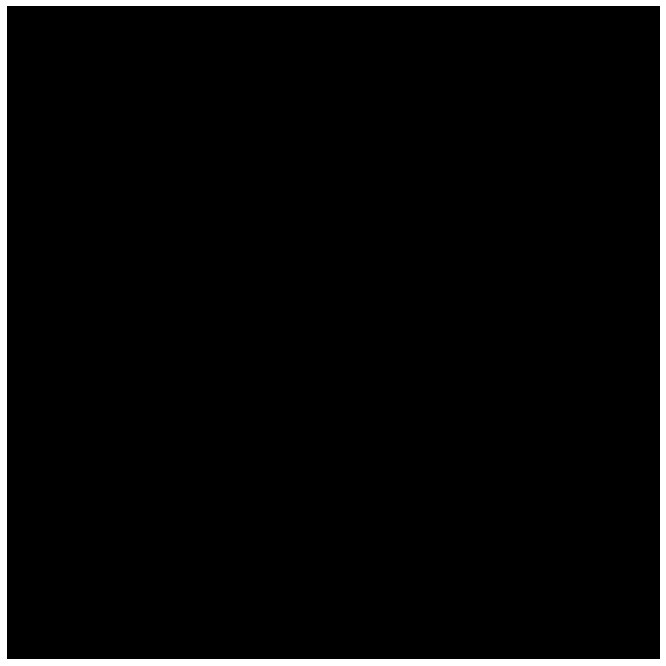

In [39]:
delta = 10
np.set_printoptions(threshold=sys.maxsize)

region_map = find_regions(newim2[70:120,70:120,:], delta)#, region_list, region_groups = find_regions(newim2[0:100,0:100,:], delta)
region_map[region_map != 0] = 255

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(region_map, cmap = 'gray')
ax.axis('off')
plt.show()

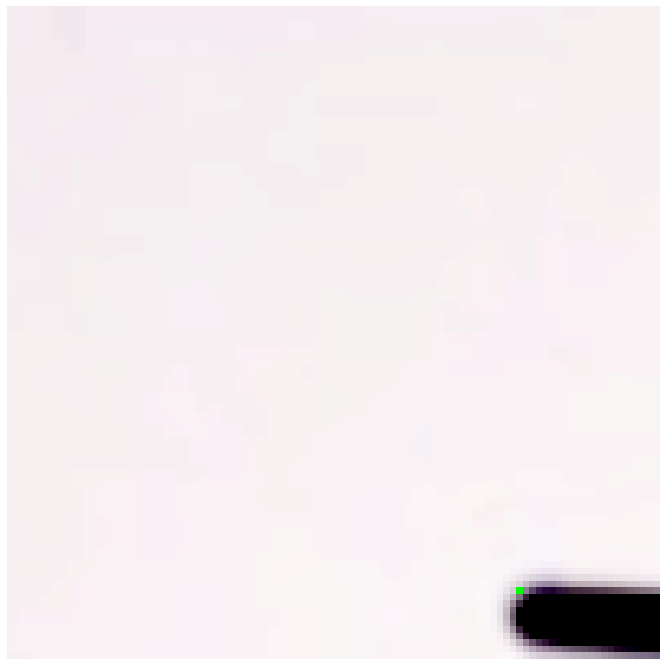

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

test = np.copy(newim2[0:100,0:100,:])
test[89,78,:] = [0,255,0]

ax.imshow(test)
ax.axis('off')
plt.show()

In [17]:
ua,uind=np.unique(region_map, return_inverse = True)
count=np.bincount(uind)
print(ua)
print(count)

[-1.  0.]
[304253   2947]


In [59]:
a = ([0], [2,3,4,5],[1,6,7])

test = np.copy(newim1[0:4,0:4,:])
print(test.shape)

test1 = test[:,:,0]
print(test1, '\n')
test2 = test[test1 == 224]
print(test2)
print(np.mean(test2,0))


print(test,'\n')

print(np.mean(test,(0,1)))

for i in range(0,0):
    print(i)

(4, 4, 3)
[[224 224 224 224]
 [224 224 224 224]
 [226 226 226 224]
 [226 226 226 224]] 

[[224 205 212]
 [224 205 212]
 [224 205 212]
 [224 205 212]
 [224 205 212]
 [224 205 212]
 [224 205 212]
 [224 205 212]
 [224 205 212]
 [224 205 212]]
[224. 205. 212.]
[[[224 205 212]
  [224 205 212]
  [224 205 212]
  [224 205 212]]

 [[224 205 212]
  [224 205 212]
  [224 205 212]
  [224 205 212]]

 [[226 207 214]
  [226 207 214]
  [226 207 214]
  [224 205 212]]

 [[226 207 214]
  [226 207 214]
  [226 207 214]
  [224 205 212]]] 

[224.75 205.75 212.75]


### 2.3 Total area (in pixels) of each color
Add your implementation and discussion